In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

print(f"TensorFlow version: {tf.__version__}")

# Crear directorio temporal
TEMP_DIR = "/tmp/embeddings_demo"
os.makedirs(TEMP_DIR, exist_ok=True)

TensorFlow version: 2.10.0


## 2. Dataset de Ejemplo: Sistema de Recomendación de Películas

Crearemos un dataset sintético que simula ratings de películas por usuarios.

In [3]:
# Generar datos sintéticos de ratings de películas
np.random.seed(42)

# Simulamos un catálogo de 1000 películas
NUM_MOVIES = 1000
NUM_USERS = 500
NUM_RATINGS = 10000

# Géneros de películas
GENRES = ['Action', 'Comedy', 'Drama', 'Sci-Fi', 'Horror', 'Romance', 'Thriller']

# Crear metadatos de películas
movie_data = {
    'movie_id': range(NUM_MOVIES),
    'genre': np.random.choice(GENRES, NUM_MOVIES),
    'year': np.random.randint(1980, 2024, NUM_MOVIES),
    'budget_millions': np.random.randint(1, 200, NUM_MOVIES)
}
movies_df = pd.DataFrame(movie_data)

# Crear ratings de usuarios
ratings_data = {
    'user_id': np.random.randint(0, NUM_USERS, NUM_RATINGS),
    'movie_id': np.random.randint(0, NUM_MOVIES, NUM_RATINGS),
    'timestamp': np.random.randint(1000000000, 1700000000, NUM_RATINGS)
}

# Crear ratings basados en preferencias de género
# Usuarios con ID bajo prefieren acción, ID alto prefieren romance
ratings = []
for i in range(NUM_RATINGS):
    user_id = ratings_data['user_id'][i]
    movie_id = ratings_data['movie_id'][i]
    genre = movies_df.loc[movie_id, 'genre']
    
    # Base rating
    rating = 3.0
    
    # Usuarios con ID bajo prefieren Action/Sci-Fi
    if user_id < 200 and genre in ['Action', 'Sci-Fi', 'Thriller']:
        rating += np.random.uniform(0.5, 2.0)
    # Usuarios con ID medio prefieren Comedy/Romance
    elif 200 <= user_id < 400 and genre in ['Comedy', 'Romance']:
        rating += np.random.uniform(0.5, 2.0)
    # Usuarios con ID alto prefieren Drama
    elif user_id >= 400 and genre in ['Drama', 'Horror']:
        rating += np.random.uniform(0.5, 2.0)
    
    # Agregar ruido
    rating += np.random.normal(0, 0.5)
    rating = np.clip(rating, 1, 5)
    ratings.append(rating)

ratings_data['rating'] = ratings
ratings_df = pd.DataFrame(ratings_data)

print(f"Dataset creado:")
print(f"- {NUM_MOVIES} películas")
print(f"- {NUM_USERS} usuarios")
print(f"- {NUM_RATINGS} ratings")
print(f"\nPrimeros registros:")
print(ratings_df.head())
print(f"\nEstadísticas de ratings:")
print(ratings_df['rating'].describe())

Dataset creado:
- 1000 películas
- 500 usuarios
- 10000 ratings

Primeros registros:
   user_id  movie_id   timestamp    rating
0      304       399  1228039469  3.493346
1      318       206  1402964540  3.456375
2      365       857  1481249443  5.000000
3      210       942  1489760268  3.450396
4      405       171  1545009935  3.347016

Estadísticas de ratings:
count    10000.000000
mean         3.421029
std          0.788650
min          1.229519
25%          2.835558
50%          3.295591
75%          3.965096
max          5.000000
Name: rating, dtype: float64


## 3. Comparación: One-Hot Encoding vs Embeddings

### Problema con One-Hot Encoding

Si tenemos 1000 películas, cada una necesita un vector de 1000 dimensiones:
- `[0, 0, 0, ..., 1, ..., 0]` (solo un 1 en la posición correspondiente)
- **Ineficiente**: 999 ceros por cada dato
- **No captura similitud**: Todas las películas están a la misma distancia

### Solución con Embeddings

Convertimos cada película a un vector denso de baja dimensión (ej: 8-32 dims):
- `[0.81, -0.32, 1.44, 0.07, -0.55, 0.22, -0.88, 0.11]`
- **Eficiente**: Vector pequeño con todos valores significativos
- **Captura similitud**: Películas similares tendrán embeddings cercanos

In [4]:
# Demostración de tamaño de memoria

# One-Hot para 1000 películas
onehot_size = NUM_MOVIES  # dimensiones
onehot_memory = NUM_MOVIES * 4  # bytes (float32)

# Embedding con dimensión 16
EMBEDDING_DIM = 16
embedding_memory = EMBEDDING_DIM * 4  # bytes

print("Comparación de memoria por película:")
print(f"One-Hot: {onehot_size} dims = {onehot_memory:,} bytes = {onehot_memory/1024:.2f} KB")
print(f"Embedding: {EMBEDDING_DIM} dims = {embedding_memory:,} bytes = {embedding_memory/1024:.2f} KB")
print(f"\nReducción de memoria: {onehot_memory/embedding_memory:.1f}x")

# Regla empírica para dimensión de embedding
recommended_dim = int(NUM_MOVIES ** 0.25)  # Cuarta raíz
print(f"\nDimensión recomendada (cuarta raíz de {NUM_MOVIES}): {recommended_dim}")

Comparación de memoria por película:
One-Hot: 1000 dims = 4,000 bytes = 3.91 KB
Embedding: 16 dims = 64 bytes = 0.06 KB

Reducción de memoria: 62.5x

Dimensión recomendada (cuarta raíz de 1000): 5


## 4. Modelo con Embeddings en TensorFlow/Keras

Crearemos un modelo de recomendación simple que aprende embeddings de usuarios y películas.

In [5]:
# Preparar datos para entrenamiento
X = ratings_df[['user_id', 'movie_id']].values
y = ratings_df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de prueba: {len(X_test)}")
print(f"\nForma de entrada: {X_train.shape}")
print(f"Forma de salida: {y_train.shape}")

Datos de entrenamiento: 8000
Datos de prueba: 2000

Forma de entrada: (8000, 2)
Forma de salida: (8000,)


In [6]:
# Modelo con Embeddings usando Functional API

# Hiperparámetros
USER_EMBEDDING_DIM = 16
MOVIE_EMBEDDING_DIM = 16

# Input layers
user_input = tf.keras.Input(shape=(1,), name='user_id', dtype=tf.int32)
movie_input = tf.keras.Input(shape=(1,), name='movie_id', dtype=tf.int32)

# Embedding layers
user_embedding = tf.keras.layers.Embedding(
    input_dim=NUM_USERS,
    output_dim=USER_EMBEDDING_DIM,
    name='user_embedding'
)(user_input)

movie_embedding = tf.keras.layers.Embedding(
    input_dim=NUM_MOVIES,
    output_dim=MOVIE_EMBEDDING_DIM,
    name='movie_embedding'
)(movie_input)

# Flatten embeddings
user_vec = tf.keras.layers.Flatten()(user_embedding)
movie_vec = tf.keras.layers.Flatten()(movie_embedding)

# Concatenar embeddings
concat = tf.keras.layers.Concatenate()([user_vec, movie_vec])

# Dense layers
dense1 = tf.keras.layers.Dense(64, activation='relu')(concat)
dense2 = tf.keras.layers.Dense(32, activation='relu')(dense1)
output = tf.keras.layers.Dense(1, name='rating')(dense2)

# Crear modelo
model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 16)        8000        ['user_id[0][0]']                
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 16)        16000       ['movie_id[0][0]']               
                                                                                              

2025-11-21 11:05:12.612649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Entrenar el modelo
history = model.fit(
    [X_train[:, 0], X_train[:, 1]],  # user_ids, movie_ids
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluar en test set
test_loss, test_mae = model.evaluate(
    [X_test[:, 0], X_test[:, 1]], 
    y_test, 
    verbose=0
)
print(f"\nTest MAE: {test_mae:.4f}")

Epoch 1/10
50/50 [==============================] - 1s 4ms/step - loss: 9.5837 - mae: 2.9674 - val_loss: 4.7325 - val_mae: 2.0231
Epoch 2/10
50/50 [==============================] - 1s 4ms/step - loss: 9.5837 - mae: 2.9674 - val_loss: 4.7325 - val_mae: 2.0231
Epoch 2/10
50/50 [==============================] - 0s 1ms/step - loss: 1.4305 - mae: 0.9534 - val_loss: 0.6921 - val_mae: 0.6696
Epoch 3/10
50/50 [==============================] - 0s 1ms/step - loss: 1.4305 - mae: 0.9534 - val_loss: 0.6921 - val_mae: 0.6696
Epoch 3/10
50/50 [==============================] - 0s 1ms/step - loss: 0.5832 - mae: 0.6176 - val_loss: 0.6876 - val_mae: 0.6728
Epoch 4/10
50/50 [==============================] - 0s 1ms/step - loss: 0.5832 - mae: 0.6176 - val_loss: 0.6876 - val_mae: 0.6728
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.5325 - mae: 0.5907 - val_loss: 0.7077 - val_mae: 0.6790
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.5325 - mae: 0.59

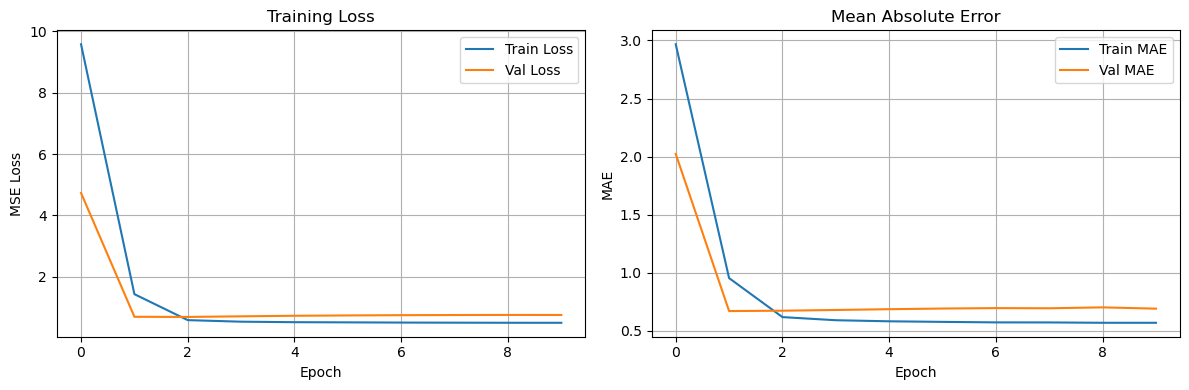

In [8]:
# Visualizar el entrenamiento
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Mean Absolute Error')
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Visualización de Embeddings

Extraemos los embeddings aprendidos y los visualizamos para ver si capturan similitudes.

In [9]:
# Extraer embeddings de películas
movie_embedding_layer = model.get_layer('movie_embedding')
movie_embeddings = movie_embedding_layer.get_weights()[0]

print(f"Forma de embeddings de películas: {movie_embeddings.shape}")
print(f"Embedding de la película 0:")
print(movie_embeddings[0])

Forma de embeddings de películas: (1000, 16)
Embedding de la película 0:
[ 0.01903125 -0.02820106 -0.0043808  -0.05598757  0.0760226  -0.02889529
 -0.06854726  0.03588802 -0.02302726 -0.01769453  0.0059861  -0.04598575
 -0.00802606 -0.0298042  -0.07041201  0.02909359]


In [10]:
# Función para encontrar películas similares
def find_similar_movies(movie_id, movie_embeddings, top_k=5):
    """Encuentra las películas más similares usando distancia coseno"""
    from sklearn.metrics.pairwise import cosine_similarity
    
    # Calcular similitud coseno
    query_embedding = movie_embeddings[movie_id].reshape(1, -1)
    similarities = cosine_similarity(query_embedding, movie_embeddings)[0]
    
    # Obtener top k más similares (excluyendo la misma película)
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    return similar_indices, similarities[similar_indices]

# Ejemplo: encontrar películas similares a la película 50
movie_id = 50
similar_movies, scores = find_similar_movies(movie_id, movie_embeddings, top_k=5)

print(f"Películas más similares a la película {movie_id}:")
print(f"Género: {movies_df.loc[movie_id, 'genre']}, Año: {movies_df.loc[movie_id, 'year']}")
print("\nTop 5 similares:")
for idx, (sim_id, score) in enumerate(zip(similar_movies, scores), 1):
    print(f"{idx}. Película {sim_id} (score: {score:.3f})")
    print(f"   Género: {movies_df.loc[sim_id, 'genre']}, Año: {movies_df.loc[sim_id, 'year']}")

Películas más similares a la película 50:
Género: Horror, Año: 1993

Top 5 similares:
1. Película 732 (score: 0.673)
   Género: Comedy, Año: 1992
2. Película 412 (score: 0.669)
   Género: Romance, Año: 2012
3. Película 767 (score: 0.658)
   Género: Action, Año: 2007
4. Película 711 (score: 0.657)
   Género: Thriller, Año: 2022
5. Película 233 (score: 0.650)
   Género: Horror, Año: 2017


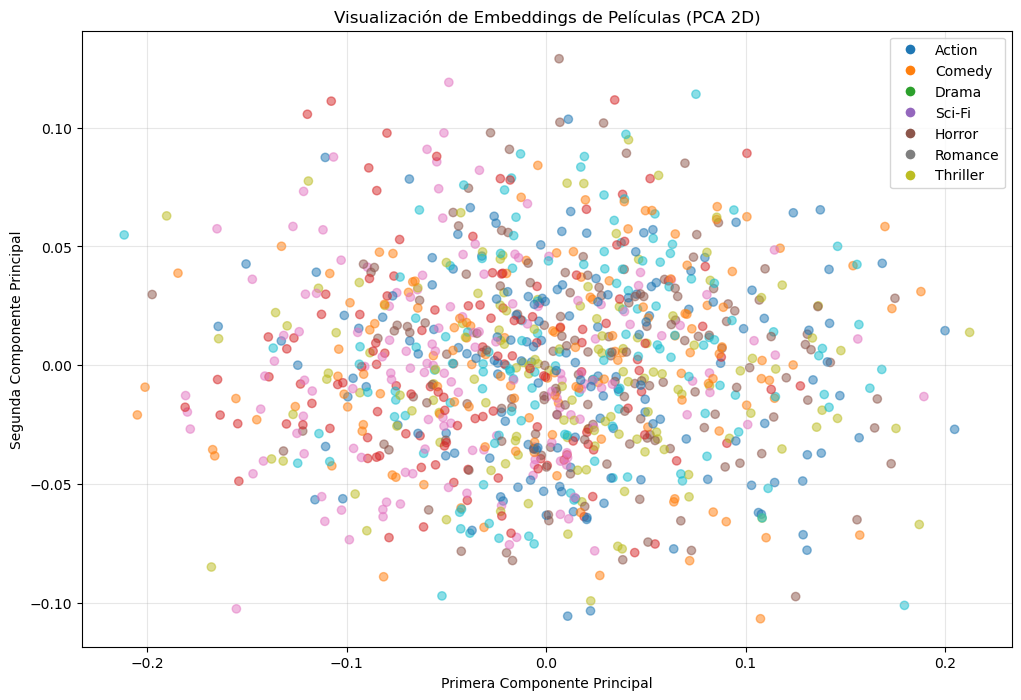

Varianza explicada por PCA: 34.67%


In [11]:
# Visualizar embeddings en 2D usando PCA
from sklearn.decomposition import PCA

# Reducir a 2 dimensiones
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(movie_embeddings)

# Crear un mapa de colores por género
genre_to_color = {genre: i for i, genre in enumerate(GENRES)}
colors = [genre_to_color[movies_df.loc[i, 'genre']] for i in range(NUM_MOVIES)]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], 
    embeddings_2d[:, 1], 
    c=colors, 
    alpha=0.5,
    cmap='tab10'
)

# Agregar leyenda
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=plt.cm.tab10(genre_to_color[genre]/len(GENRES)), 
                              label=genre, markersize=8)
                  for genre in GENRES]
plt.legend(handles=legend_elements, loc='upper right')

plt.title('Visualización de Embeddings de Películas (PCA 2D)')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

## 6. Feature Crosses con Embeddings

Feature crosses combinan múltiples features categóricas para capturar interacciones no lineales.

Ejemplo: `(género × año_decada)` puede capturar que "Acción en los 80s" es diferente de "Acción en los 2020s".

In [12]:
# Agregar metadatos al dataset de ratings
ratings_with_meta = ratings_df.merge(movies_df[['movie_id', 'genre', 'year']], on='movie_id')

# Crear feature cross: década × género
ratings_with_meta['decade'] = (ratings_with_meta['year'] // 10) * 10
ratings_with_meta['genre_decade'] = (
    ratings_with_meta['genre'] + '_' + 
    ratings_with_meta['decade'].astype(str)
)

print("Feature cross creado: género × década")
print(f"\nEjemplos de valores únicos:")
print(ratings_with_meta['genre_decade'].unique()[:10])
print(f"\nTotal de combinaciones únicas: {ratings_with_meta['genre_decade'].nunique()}")

# Mostrar algunos ejemplos
print("\nEjemplos de datos con feature cross:")
print(ratings_with_meta[['user_id', 'movie_id', 'genre', 'decade', 'genre_decade', 'rating']].head(10))

Feature cross creado: género × década

Ejemplos de valores únicos:
['Action_2000' 'Sci-Fi_2010' 'Comedy_2000' 'Horror_2010' 'Comedy_1980'
 'Comedy_1990' 'Action_1990' 'Romance_2000' 'Horror_1990' 'Romance_1980']

Total de combinaciones únicas: 35

Ejemplos de datos con feature cross:
   user_id  movie_id   genre  decade genre_decade    rating
0      304       399  Action    2000  Action_2000  3.493346
1      121       399  Action    2000  Action_2000  3.525578
2      245       399  Action    2000  Action_2000  2.895236
3       17       399  Action    2000  Action_2000  5.000000
4      436       399  Action    2000  Action_2000  3.449382
5      308       399  Action    2000  Action_2000  3.962564
6      391       399  Action    2000  Action_2000  2.434261
7      318       206  Sci-Fi    2010  Sci-Fi_2010  3.456375
8      161       206  Sci-Fi    2010  Sci-Fi_2010  3.327895
9      397       206  Sci-Fi    2010  Sci-Fi_2010  2.410529


In [13]:
# Modelo con feature cross

# Convertir genre_decade a IDs numéricos
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
ratings_with_meta['genre_decade_id'] = le.fit_transform(ratings_with_meta['genre_decade'])
NUM_GENRE_DECADES = len(le.classes_)

print(f"Número de combinaciones género×década: {NUM_GENRE_DECADES}")

# Preparar datos
X_cross = ratings_with_meta[['user_id', 'movie_id', 'genre_decade_id']].values
y_cross = ratings_with_meta['rating'].values

X_train_cross, X_test_cross, y_train_cross, y_test_cross = train_test_split(
    X_cross, y_cross, test_size=0.2, random_state=42
)

# Crear modelo con feature cross
user_input = tf.keras.Input(shape=(1,), name='user_id', dtype=tf.int32)
movie_input = tf.keras.Input(shape=(1,), name='movie_id', dtype=tf.int32)
genre_decade_input = tf.keras.Input(shape=(1,), name='genre_decade', dtype=tf.int32)

# Embeddings
user_emb = tf.keras.layers.Flatten()(
    tf.keras.layers.Embedding(NUM_USERS, 16)(user_input)
)
movie_emb = tf.keras.layers.Flatten()(
    tf.keras.layers.Embedding(NUM_MOVIES, 16)(movie_input)
)
genre_decade_emb = tf.keras.layers.Flatten()(
    tf.keras.layers.Embedding(NUM_GENRE_DECADES, 8)(genre_decade_input)
)

# Concatenar todos
concat = tf.keras.layers.Concatenate()([user_emb, movie_emb, genre_decade_emb])

# Dense layers
x = tf.keras.layers.Dense(64, activation='relu')(concat)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
output = tf.keras.layers.Dense(1)(x)

model_cross = tf.keras.Model(
    inputs=[user_input, movie_input, genre_decade_input], 
    outputs=output
)

model_cross.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nModelo con feature cross:")
model_cross.summary()

Número de combinaciones género×década: 35

Modelo con feature cross:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_id (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 movie_id (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 genre_decade (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 16)        8000        ['user_id[0][0]']                
                       

In [14]:
# Entrenar modelo con feature cross
history_cross = model_cross.fit(
    [X_train_cross[:, 0], X_train_cross[:, 1], X_train_cross[:, 2]],
    y_train_cross,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    verbose=1
)

# Evaluar
test_loss_cross, test_mae_cross = model_cross.evaluate(
    [X_test_cross[:, 0], X_test_cross[:, 1], X_test_cross[:, 2]],
    y_test_cross,
    verbose=0
)

print(f"\nModelo sin feature cross - Test MAE: {test_mae:.4f}")
print(f"Modelo con feature cross - Test MAE: {test_mae_cross:.4f}")
print(f"Mejora: {((test_mae - test_mae_cross) / test_mae * 100):.2f}%")

Epoch 1/10
50/50 [==============================] - 0s 3ms/step - loss: 8.9452 - mae: 2.8366 - val_loss: 3.0563 - val_mae: 1.5526
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 8.9452 - mae: 2.8366 - val_loss: 3.0563 - val_mae: 1.5526
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 1.0589 - mae: 0.8254 - val_loss: 0.6765 - val_mae: 0.6509
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 1.0589 - mae: 0.8254 - val_loss: 0.6765 - val_mae: 0.6509
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6538 - mae: 0.6502 - val_loss: 0.6552 - val_mae: 0.6539
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6538 - mae: 0.6502 - val_loss: 0.6552 - val_mae: 0.6539
Epoch 4/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6093 - mae: 0.6295 - val_loss: 0.6712 - val_mae: 0.6642
Epoch 5/10
50/50 [==============================] - 0s 2ms/step - loss: 0.6093 - mae: 0.62

## 7. Embeddings Pre-entrenados: Word Embeddings

Los embeddings también se usan en NLP. Aquí mostramos un ejemplo simple con embeddings de palabras.

In [15]:
# Ejemplo simple de word embeddings

# Vocabulario pequeño
vocab = ['action', 'comedy', 'drama', 'sci-fi', 'horror', 
         'movie', 'film', 'watch', 'rating', 'good']
vocab_size = len(vocab)

# Crear índice de palabras
word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# Crear modelo de embedding de palabras
word_input = tf.keras.Input(shape=(1,), dtype=tf.int32)
word_embedding = tf.keras.layers.Embedding(
    input_dim=vocab_size,
    output_dim=8,
    name='word_embedding'
)(word_input)
word_vec = tf.keras.layers.Flatten()(word_embedding)

word_model = tf.keras.Model(inputs=word_input, outputs=word_vec)

# Inicializar con algunos pesos aleatorios (normalmente se entrenarían)
word_model.layers[1].set_weights([np.random.randn(vocab_size, 8) * 0.1])

print("Word embeddings creados")
print(f"Vocabulario: {vocab}")
print(f"\nEmbedding de la palabra 'action' (índice {word_to_idx['action']}):")
action_embedding = word_model.predict([[word_to_idx['action']]], verbose=0)
print(action_embedding)

Word embeddings creados
Vocabulario: ['action', 'comedy', 'drama', 'sci-fi', 'horror', 'movie', 'film', 'watch', 'rating', 'good']

Embedding de la palabra 'action' (índice 0):
[[-0.03974701 -0.10053965  0.09242147 -0.03344734 -0.02266622 -0.13275284
   0.20716359  0.24270675]]


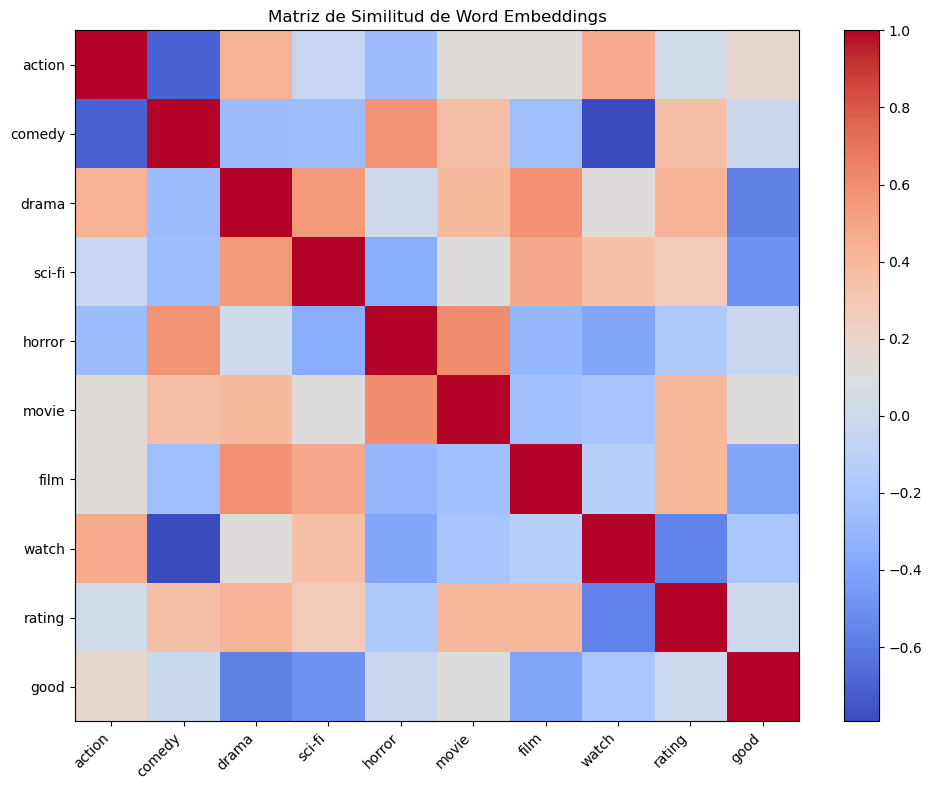


Palabras más similares a 'action':
1. watch (similitud: 0.464)
2. drama (similitud: 0.431)
3. good (similitud: 0.178)

Palabras más similares a 'movie':
1. horror (similitud: 0.608)
2. rating (similitud: 0.395)
3. drama (similitud: 0.389)


In [16]:
# Calcular similitud entre palabras
from sklearn.metrics.pairwise import cosine_similarity

# Obtener todos los embeddings
all_word_embeddings = word_model.layers[1].get_weights()[0]

# Calcular matriz de similitud
similarity_matrix = cosine_similarity(all_word_embeddings)

# Mostrar similitudes
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='coolwarm', aspect='auto')
plt.colorbar(im)
plt.xticks(range(vocab_size), vocab, rotation=45, ha='right')
plt.yticks(range(vocab_size), vocab)
plt.title('Matriz de Similitud de Word Embeddings')
plt.tight_layout()
plt.show()

# Encontrar palabras más similares
def find_similar_words(word, top_k=3):
    idx = word_to_idx[word]
    similarities = similarity_matrix[idx]
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]
    
    print(f"\nPalabras más similares a '{word}':")
    for rank, sim_idx in enumerate(similar_indices, 1):
        print(f"{rank}. {vocab[sim_idx]} (similitud: {similarities[sim_idx]:.3f})")

find_similar_words('action')
find_similar_words('movie')

## 8. Hacer Recomendaciones con el Modelo

Usemos el modelo entrenado para hacer predicciones y recomendar películas.

In [17]:
# Función para recomendar películas a un usuario
def recommend_movies_for_user(user_id, model, movies_df, top_k=5):
    """Recomienda las top k películas para un usuario"""
    
    # Predecir ratings para todas las películas
    movie_ids = np.arange(NUM_MOVIES)
    user_ids = np.full(NUM_MOVIES, user_id)
    
    predictions = model.predict([user_ids, movie_ids], verbose=0).flatten()
    
    # Obtener top k
    top_indices = np.argsort(predictions)[::-1][:top_k]
    
    recommendations = []
    for idx in top_indices:
        recommendations.append({
            'movie_id': idx,
            'predicted_rating': predictions[idx],
            'genre': movies_df.loc[idx, 'genre'],
            'year': movies_df.loc[idx, 'year']
        })
    
    return recommendations

# Recomendar para el usuario 25
user_id = 25
recommendations = recommend_movies_for_user(user_id, model, movies_df, top_k=10)

print(f"Top 10 recomendaciones para Usuario {user_id}:")
print("-" * 70)
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. Película {rec['movie_id']} | Rating predicho: {rec['predicted_rating']:.2f} | "
          f"Género: {rec['genre']} | Año: {rec['year']}")

Top 10 recomendaciones para Usuario 25:
----------------------------------------------------------------------
1. Película 717 | Rating predicho: 4.42 | Género: Sci-Fi | Año: 1984
2. Película 255 | Rating predicho: 4.41 | Género: Action | Año: 2009
3. Película 334 | Rating predicho: 4.39 | Género: Horror | Año: 2015
4. Película 704 | Rating predicho: 4.39 | Género: Thriller | Año: 2004
5. Película 516 | Rating predicho: 4.37 | Género: Romance | Año: 2006
6. Película 902 | Rating predicho: 4.36 | Género: Comedy | Año: 1998
7. Película 387 | Rating predicho: 4.35 | Género: Romance | Año: 2009
8. Película 806 | Rating predicho: 4.34 | Género: Action | Año: 2018
9. Película 259 | Rating predicho: 4.32 | Género: Comedy | Año: 2008
10. Película 825 | Rating predicho: 4.32 | Género: Sci-Fi | Año: 2003


In [18]:
# Analizar el perfil del usuario basado en sus ratings anteriores
user_ratings = ratings_df[ratings_df['user_id'] == user_id].merge(
    movies_df[['movie_id', 'genre']], on='movie_id'
)

print(f"\nPerfil del Usuario {user_id}:")
print(f"Total de ratings: {len(user_ratings)}")
print(f"Rating promedio: {user_ratings['rating'].mean():.2f}")
print(f"\nGéneros más vistos:")
genre_counts = user_ratings['genre'].value_counts()
print(genre_counts.head())

# Comparar con recomendaciones
rec_genres = pd.DataFrame(recommendations)['genre'].value_counts()
print(f"\nGéneros en recomendaciones:")
print(rec_genres)


Perfil del Usuario 25:
Total de ratings: 25
Rating promedio: 3.74

Géneros más vistos:
Thriller    5
Comedy      5
Sci-Fi      5
Horror      4
Romance     3
Name: genre, dtype: int64

Géneros en recomendaciones:
Comedy      2
Romance     2
Action      2
Sci-Fi      2
Horror      1
Thriller    1
Name: genre, dtype: int64
